# Equal-sized Bins Clustering
Commutative-ly combine splats of similar depth to reduce sorting and improve performance.

In [1]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of bins to use.
NUMBER_OF_BINS = 5

In [2]:
from clustering_exploration.utils.data_handler import load_splats
splats = load_splats(DATA_NAME)

# Cluster Splats
- Create N bins from the minimum non-zero depth to the maximum depth.
- For each pixel, collect splats into bins based on their depth.
- In each bin, sum the premultiplied colors and sum the alphas.

In [3]:
from clustering_exploration.algorithms.binned import BinnedAlgorithm
clustered_splats = BinnedAlgorithm(splats, NUMBER_OF_BINS).shuffle_and_compute()

Min depth: 1.2029399871826172, Max depth: 11.86460018157959
Each bin will be 2.1323320865631104 units wide.
Shuffling splats...
Clustering splats...


  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Bins

  0%|          | 0/1051648 [00:00<?, ?it/s]

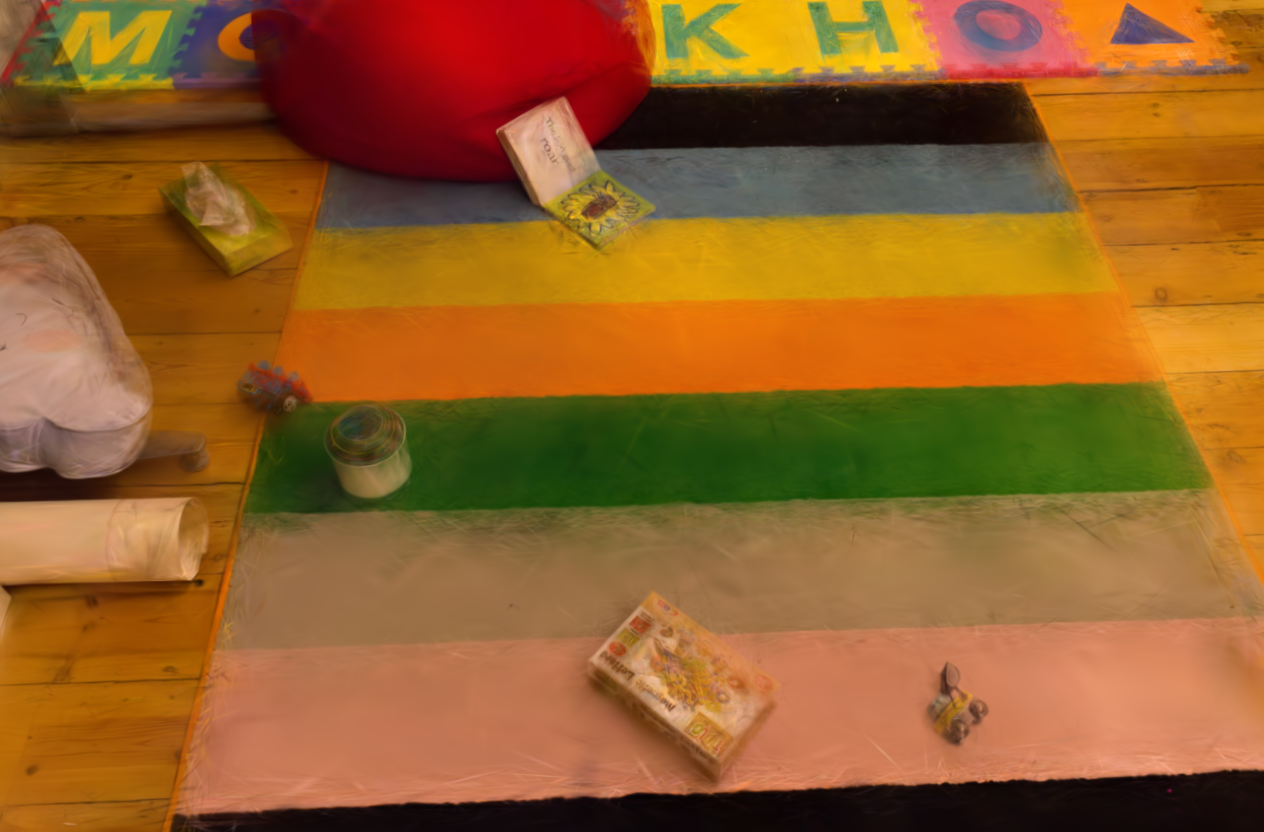

In [4]:
from clustering_exploration.utils.image_handler import compute_image_from_clusters
display(compute_image_from_clusters(clustered_splats, "binned_clustering"))